In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy

# Adding library directory to python search path
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

# Create directory for generated .tex and .pdf
if not os.path.exists('gen'):
    os.mkdir('gen')

In [31]:
class consts:
    pi = 3.141592
    c  = 3 * 10**8 # m/s
    mu_0 = 4 * pi * 10**-7 # N * A^-2
    e = 1.6 * 10**-19 # C

    k = 1.38 * 10**-23 # J/K

class cgs:
    k = 1.38 * 10**-16 # erg/K
    e = 4.8 * 10**-10 # Franklin

class setup:
    dummy = 0

    Cu_sigma = 5 * 10**7 # Sm/m
    h = 1.4 * 10**-3 # m
    a = 21 * 10**-3 # m
    

In [32]:
raw_data = mipt.read_excel('data/77.ods', usecols=('A', 'B', 'C', 'E', 'F', 'G', 'I', 'J', 'K', 'M', 'N', 'O', 'Q', 'R', 'S', 'U', 'V', 'W'), header=(0, 1)).dropna(how='all')

xsl = {
    "2Uout, V" : "out",
    "2Ua, V" : "a",
    "2Uin, V" : "in"
}

raw_data = mipt.map_excel(raw_data, xsl)
raw_data

2-AFC                   3-AFC              3-Repeater              \
          f    out      a         f   out     in          f   out    in   
0      50.0  5.750  0.022      50.0  9.60  0.093         10  1.92  1.92   
1     100.0  5.760  0.043     100.0  9.70  0.097      10000  1.95  1.95   
2     200.0  5.760  0.086     200.0  9.70  0.097     100000  1.95  1.95   
3     500.0  5.710  0.211     500.0  9.70  0.097     200000  1.97  1.95   
4    1000.0  5.630  0.423    1000.0  9.60  0.097     280000  2.03  1.95   
5    2000.0  5.270  0.789    2000.0  9.60  0.097     300000  2.11  1.95   
6    5000.0  3.850  1.410    5000.0  9.20  0.097     350000  2.16  1.95   
7   10000.0  2.360  1.730   10000.0  7.98  0.097     400000  1.83  1.95   
8   20000.0  1.236  1.830   15000.0  6.63  0.097     450000  1.85  1.95   
9   50000.0  0.505  1.770   20000.0  5.57  0.097     480000  1.70  1.95   
10      NaN    NaN    NaN   30000.0  4.00  0.097     500000  1.40  1.95   
11      NaN    NaN    NaN   50000.0  2.55  0.097     580000  1.20  1.95   
12      NaN    NaN    NaN  100000.0  1.25  0.096     600000  1.04  1.95   
13      NaN    NaN    NaN       NaN   NaN    NaN     700000  0.90  1.95   
14      NaN    NaN    NaN       NaN   NaN    NaN     800000  0.65  1.95   

       4-AFC                 5-First                 5-Second                
           f   out     in          f    out     in          f    out     in  
0       10.0  8.97  0.090       10.0  0.935  0.183       10.0  0.953  0.187  
1      100.0  9.00  0.090     1000.0  0.956  0.187     1000.0  0.975  0.191  
2     1000.0  9.13  0.092    10000.0  0.949  0.185    10000.0  0.966  0.190  
3     5000.0  8.76  0.092    50000.0  0.930  0.185    50000.0  0.943  0.188  
4    10000.0  7.67  0.092   100000.0  0.868  0.185   100000.0  0.875  0.188  
5    15000.0  6.41  0.093   200000.0  0.722  0.189   200000.0  0.711  0.190  
6    30000.0  4.00  0.094   300000.0  0.590  0.190   300000.0  0.575  0.190  
7    50000.0  2.55  0.095   400000.0  0.482  0.189   400000.0  0.470  0.190  
8   100000.0  1.27  0.095   600000.0  0.352  0.190   600000.0  0.348  0.190  
9        NaN   NaN    NaN   800000.0  0.260  0.190   800000.0  0.262  0.190  
10       NaN   NaN    NaN  1000000.0  0.199  0.190  1000000.0  0.205  0.189  
11       NaN   NaN    NaN        NaN    NaN    NaN        NaN    NaN    NaN  
12       NaN   NaN    NaN        NaN    NaN    NaN        NaN    NaN    NaN  
13       NaN   NaN    NaN        NaN    NaN    NaN        NaN    NaN    NaN  
14       NaN   NaN    NaN        NaN    NaN    NaN        NaN    NaN    NaN

## 2

f_T = 1.44e+06
f_p0 = 1.42e+00
131257.50250334007


,<x>,sx,<y>,sy,rxy,a,da,b,db
0,3.169897,0.914156,59.301171,360.025796,-18.141309,-19.844865,0.043712,122.207347,0.14473


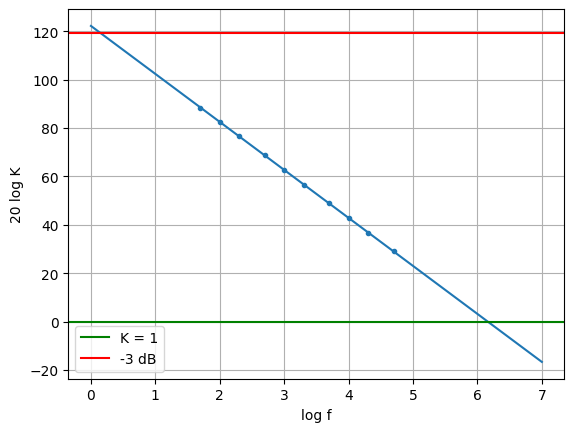

In [33]:
data = raw_data["2-AFC"].dropna()
k = data["out"] / data["a"] * (1 + 1e5 / 1e3)

x, y, equ = mipt.plot(np.log10(data["f"]), 20 * np.log10(k), x_min = 0, x_max = 7)
mnk_dat = mipt.mnk(x, y)
b = mnk_dat.data['b'][0]
a = mnk_dat.data['a'][0]

plt.axhline(0, color='g', label="K = 1")
f_T = 10 ** ((0 - b) / a)
print("f_T = {:.2e}".format(f_T))
plt.axhline(b - 3, color='r', label="-3 dB")
f_p0 = 10 ** ((b-3 - b) / a)
print("f_p0 = {:.2e}".format(f_p0))

plt.xlabel("log f")
plt.ylabel("20 log K")
plt.grid(True)
plt.legend()
plt.savefig("gen/2-afc.pdf")
print (10 ** (equ(1) / 20))

mnk_dat.data

## 3-4

K_0 = 103.2258064516129
K_0 = 100.0
F_p = 15848.93192461114 Hz
R2/R1 = 100
F_p = f_T / (R2/R1) = 14392.44558913668


,f,out,in
0,10.0,8.97,0.090
1,100.0,9.00,0.090
2,1000.0,9.13,0.092
3,5000.0,8.76,0.092
4,10000.0,7.67,0.092
5,15000.0,6.41,0.093
6,30000.0,4.00,0.094
7,50000.0,2.55,0.095
8,100000.0,1.27,0.095


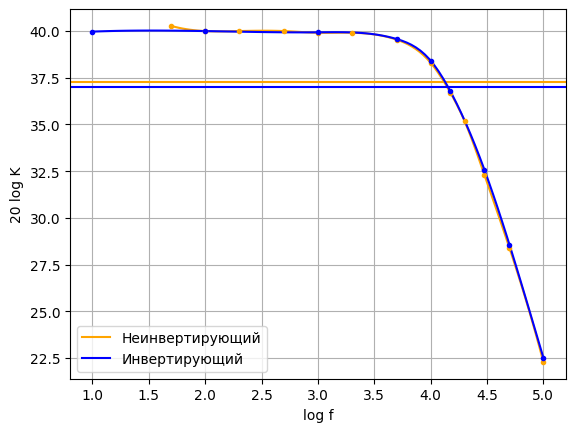

In [34]:
def interp(x, y):
    return UnivariateSpline(x, y, s=0)

def plot(f, input, output, label, col):
    x, y, _ = mipt.plot(np.log10(f), 20 * np.log10(output/input), func=interp, label=label, color=col)
    plt.axhline(np.max(y) - 3, color=col)
    print("K_0 = {}".format(np.max(output/input)))

data = raw_data["3-AFC"].dropna()
plot(data["f"], data["in"], data["out"], "Неинвертирующий", 'orange')
data = raw_data["4-AFC"].dropna()
plot(data["f"], data["in"], data["out"], "Инвертирующий", 'blue')

plt.xlabel("log f")
plt.ylabel("20 log K")
plt.grid(True)
plt.legend()
plt.savefig("gen/3-4-afc.pdf")

print("F_p = {} Hz".format(10 ** (4.2)))
print("R2/R1 = 100")
print("F_p = f_T / (R2/R1) = {}".format(f_T / 100))
data

## 5

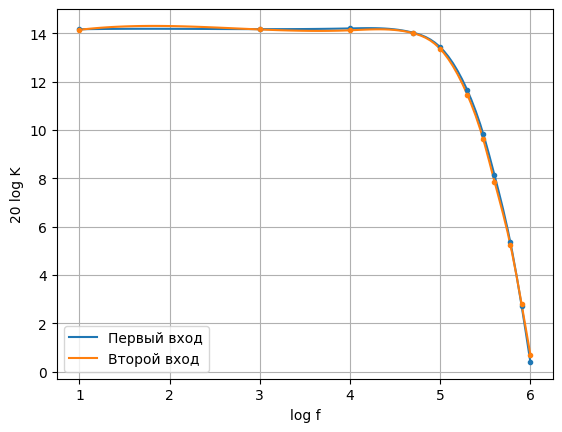

In [35]:
first = raw_data["5-First"].dropna()
second = raw_data["5-Second"].dropna()

def plot(f, input, output, label):
    mipt.plot(np.log10(f), 20 * np.log10(output/input), func=interp, label=label)

plot(first['f'], first['in'], first['out'], "Первый вход")
plot(second['f'], second['in'], second['out'], "Второй вход")

plt.xlabel("log f")
plt.ylabel("20 log K")
plt.grid(True)


plt.legend()
plt.savefig("gen/5-single.pdf")
